In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_step = combinators.PrimitiveCall(ssm.ssm_step)
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_sequence = combinators.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1), initializer=ssm_initializer)

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = combinators.PrimitiveCall(ssm.ssm_step)
smc_ssm = importance.smc(ssm_step_generative, particle_shape, lambda: range(50), initializer=init_ssm_generative)

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = combinators.PrimitiveCall(ssm.ssm_step)
ssm_proposal = combinators.Reduce(ssm_step_proposal, generator=lambda: range(50), initializer=init_ssm_proposal)

In [11]:
ssm_score = combinators.ProposalScore(ssm_proposal, smc_ssm)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_score, 1000, data, use_cuda=False,
    lr=1e-1, patience=500
)

11/07/2018 17:39:44 ELBO=-1.77730560e+00 at epoch 1
11/07/2018 17:39:44 ELBO=-1.56399918e+00 at epoch 2
11/07/2018 17:39:44 ELBO=-1.51663995e+00 at epoch 3
11/07/2018 17:39:44 ELBO=-1.53697872e+00 at epoch 4
11/07/2018 17:39:44 ELBO=-1.59738445e+00 at epoch 5
11/07/2018 17:39:45 ELBO=-1.42513895e+00 at epoch 6
11/07/2018 17:39:45 ELBO=-1.37905645e+00 at epoch 7
11/07/2018 17:39:45 ELBO=-1.35690928e+00 at epoch 8
11/07/2018 17:39:45 ELBO=-1.34534025e+00 at epoch 9
11/07/2018 17:39:45 ELBO=-1.30966091e+00 at epoch 10
11/07/2018 17:39:45 ELBO=-1.30843258e+00 at epoch 11
11/07/2018 17:39:46 ELBO=-1.28010225e+00 at epoch 12
11/07/2018 17:39:46 ELBO=-1.27319670e+00 at epoch 13
11/07/2018 17:39:46 ELBO=-1.31490374e+00 at epoch 14
11/07/2018 17:39:46 ELBO=-1.35895252e+00 at epoch 15
11/07/2018 17:39:46 ELBO=-1.30893755e+00 at epoch 16
11/07/2018 17:39:47 ELBO=-1.33544350e+00 at epoch 17
11/07/2018 17:39:47 ELBO=-1.39950180e+00 at epoch 18
11/07/2018 17:39:47 ELBO=-1.26377344e+00 at epoch 19
11

Epoch   821: reducing learning rate of group 0 to 5.0000e-02.


11/07/2018 17:42:13 ELBO=-1.18595791e+00 at epoch 824
11/07/2018 17:42:13 ELBO=-1.22404051e+00 at epoch 825
11/07/2018 17:42:13 ELBO=-1.16207123e+00 at epoch 826
11/07/2018 17:42:13 ELBO=-1.28184652e+00 at epoch 827
11/07/2018 17:42:13 ELBO=-1.24479198e+00 at epoch 828
11/07/2018 17:42:14 ELBO=-1.29217243e+00 at epoch 829
11/07/2018 17:42:14 ELBO=-1.21214724e+00 at epoch 830
11/07/2018 17:42:14 ELBO=-1.28513622e+00 at epoch 831
11/07/2018 17:42:14 ELBO=-1.33905506e+00 at epoch 832
11/07/2018 17:42:14 ELBO=-1.24371481e+00 at epoch 833
11/07/2018 17:42:14 ELBO=-1.23845005e+00 at epoch 834
11/07/2018 17:42:15 ELBO=-1.24507380e+00 at epoch 835
11/07/2018 17:42:15 ELBO=-1.35849237e+00 at epoch 836
11/07/2018 17:42:15 ELBO=-1.28630924e+00 at epoch 837
11/07/2018 17:42:15 ELBO=-1.25531864e+00 at epoch 838
11/07/2018 17:42:15 ELBO=-1.24079084e+00 at epoch 839
11/07/2018 17:42:15 ELBO=-1.23834896e+00 at epoch 840
11/07/2018 17:42:16 ELBO=-1.22806120e+00 at epoch 841
11/07/2018 17:42:16 ELBO=-1.

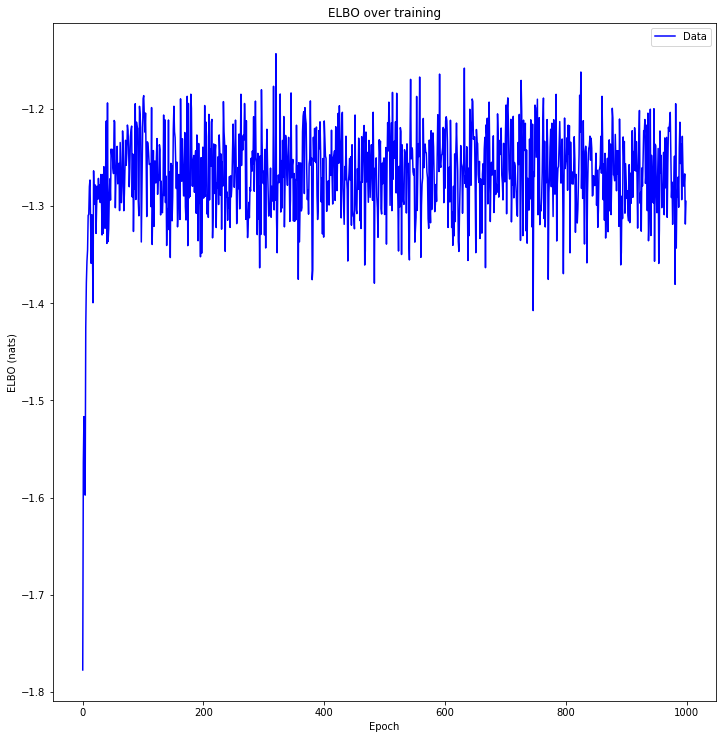

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 1.913075


KeyError: 'Z_2'

In [ ]:
particle_mh = mcmc.IndependentMH(smc_ssm, ssm_proposal, 1000)

In [ ]:
samples, elbos = particle_mh(trace=importance.ResamplerTrace(num_particles, data=data))
inference = particle_mh.trace

In [ ]:
inference

In [ ]:
generative

In [ ]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

In [ ]:
elbos